# 在保险公司中应用决策树算法进行用户分类

## 读入数据

In [1]:
import numpy as np
import pandas as pd

In [3]:
df = pd.read_csv('./data/ma_resp_data_temp.csv', header = 0)

In [4]:
df.head()

,KBM_INDV_ID,resp_flag,GEND,CA00,CA03,CA06,CA11,CA16,AART,ADBT,...,c210pmr,c210poo,c210psu,c210pwc,c210wht,ilor,meda,pdpe,tins,zhip19
0,281478,0,M,4,0,5,1,1,N,N,...,52,65,71.0,22,79.0,15.0,64.0,42,8,8
1,290485,0,M,0,0,0,0,0,N,N,...,44,81,99.0,37,65.0,17.0,61.0,46,6,3
2,299949,0,F,0,0,0,0,0,N,N,...,38,44,62.0,44,47.0,20.0,61.0,46,7,3
3,314635,0,F,0,4,0,0,0,N,N,...,45,71,99.0,39,71.0,4.0,62.0,37,8,9
4,363702,0,F,0,0,0,0,0,N,N,...,32,13,36.0,15,65.0,9.0,NaN,37,4,3


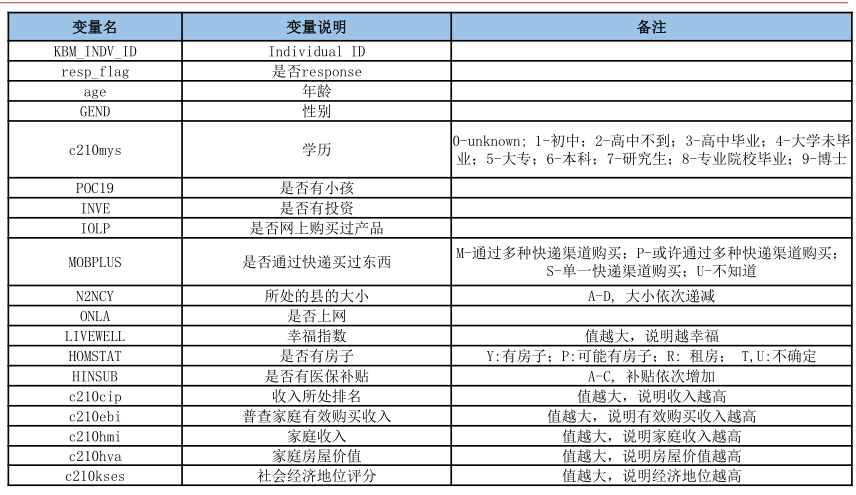

## 了解数据

In [6]:
#df.info()

In [7]:
df.columns

Index(['KBM_INDV_ID', 'resp_flag', 'GEND', 'CA00', 'CA03', 'CA06', 'CA11',
       'CA16', 'AART', 'ADBT', 'ADEP', 'AHBP', 'AHCH', 'ARES', 'AHRT', 'AASN',
       'ADGS', 'AHRL', 'ASKN', 'AVIS', 'BANK', 'COLLEGE', 'FINI', 'INLI',
       'INMEDI', 'INVE', 'IOLP', 'MOBPLUS', 'N2NCY', 'NY8Y9', 'N2N29', 'N3N39',
       'N4N49', 'N5N59', 'N6N64', 'N65P', 'ONLA', 'POEP', 'SGFA', 'SGLL',
       'SGOE', 'SGSE', 'SGTC', 'U18', 'LIVEWELL', 'NOC19', 'NAH19', 'NPH19',
       'POC19', 'HOMSTAT', 'HINSUB', 'STATE_NAME', 'age', 'c210apvt',
       'c210b200', 'c210blu', 'c210bpvt', 'c210cip', 'c210ebi', 'c210hmi',
       'c210hva', 'c210kses', 'c210mah', 'c210mob', 'c210mys', 'c210pdv',
       'c210pmr', 'c210poo', 'c210psu', 'c210pwc', 'c210wht', 'ilor', 'meda',
       'pdpe', 'tins', 'zhip19'],
      dtype='object')

In [9]:
df.drop('KBM_INDV_ID', axis = 1, inplace = True)

In [12]:
label = df.pop('resp_flag')
df['label'] = label

In [16]:
# 记录最初的数据类型，并保存下来，方便后面进行对比
df_org = df.copy()

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43666 entries, 0 to 43665
Data columns (total 76 columns):
KBM_INDV_ID    43666 non-null int64
resp_flag      43666 non-null int64
GEND           43666 non-null object
CA00           43666 non-null int64
CA03           43666 non-null int64
CA06           43666 non-null int64
CA11           43666 non-null int64
CA16           43666 non-null int64
AART           43666 non-null object
ADBT           43666 non-null object
ADEP           43666 non-null object
AHBP           43666 non-null object
AHCH           43666 non-null object
ARES           43666 non-null object
AHRT           43666 non-null object
AASN           43656 non-null object
ADGS           43666 non-null object
AHRL           43666 non-null object
ASKN           43658 non-null object
AVIS           43666 non-null object
BANK           43666 non-null object
COLLEGE        43658 non-null object
FINI           43666 non-null object
INLI           43666 non-null object
INMEDI    

注： 第一列是用户ID，这一列作为数值存在时没有意义的，我们为了查看统计信息，把这一列改成字符型

In [9]:
#df.describe().T

把这个统计值保存下来，方便后面查看

### 统计一下每一列中有多少个空值

统计有多少列中是有空值的

In [23]:
# 检查是否有缺失的列
NA = df.isnull().sum()

统计各个列中空值的数量

In [26]:
NA = NA.reset_index()

In [28]:
NA.columns = ['features', 'Missing_count']
NA

,features,Missing_count
0,GEND,0
1,CA00,0
2,CA03,0
3,CA06,0
4,CA11,0
...,...,...
70,meda,15
71,pdpe,0
72,tins,0
73,zhip19,0


将那些不为零的数据过滤出来

In [34]:
# 过滤出大于0的数据
NA = NA[NA['Missing_count'] > 0].reset_index(drop = True)

In [47]:
# 把空值比例，换算成比例

# NA['Missing_count'] / df.shape[0] * 100

In [46]:
# 发现保留位数太多，改变成保留小数点后两位

# np.around(NA['Missing_count'] / df.shape[0] * 100, 3)

**结论： 各个特征中空值所占百分比很低，没有需要因为空值太多而需要删除的列**

## 查看数据中是否有重复值

In [76]:
df[df.duplicated()]
df.drop_duplicates(inplace = True)

## 可视化数据查看数据分布情况

In [80]:
# 引入画图模块
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [81]:
plt.style.use('seaborn')

In [82]:
# 支持中文
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

### 看一下目标变量是否平衡

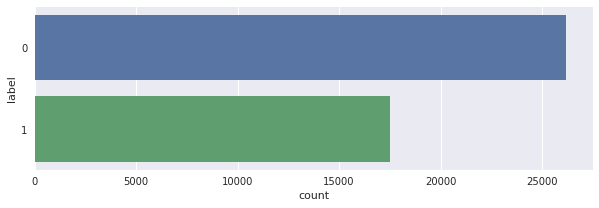

In [86]:
# 查看性别比例
plt.figure(1 , figsize = (10 , 3))
sns.countplot(y = 'label' , data = df)
plt.show()

**统计购买用户和未购买用户的比例关系**

In [98]:
df['label'].value_counts()/df.shape[0]

0    0.599482
1    0.400518
Name: label, dtype: float64

**购买保险用户相对较少一些,但相对比较平衡**

### 绘制年龄分布情况

**根据我们对于保险行业的经验, 年龄对于购买保险应该是一个非常重要的属性**

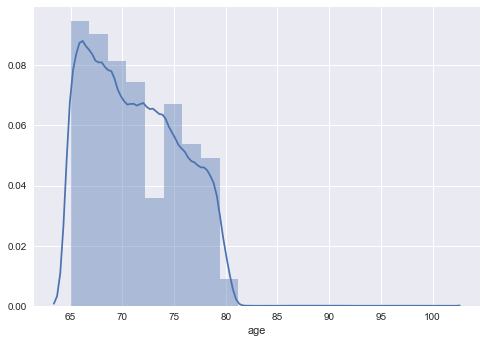

In [73]:
sns.distplot(df['age'],bins=20)

In [74]:
df['age'].max()

101.0

In [75]:
df['age'].min()

65.0

### 分别绘制两类样本的年龄分布

D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
D:\Anaconda\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


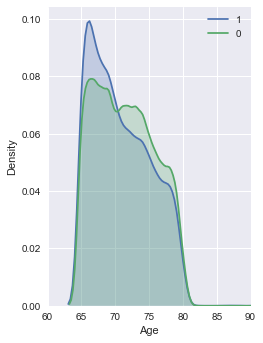

In [98]:
# 为连续型变量：年龄创建密度图 
plt.subplot(1, 2, 2)
sns.kdeplot(df.age[df.resp_flag==1], label='1', shade=True)
sns.kdeplot(df.age[df.resp_flag==0], label='0', shade=True)
plt.xlim(([60,90]))
plt.xlabel('Age');
plt.ylabel('Density');

### 查看性别比例

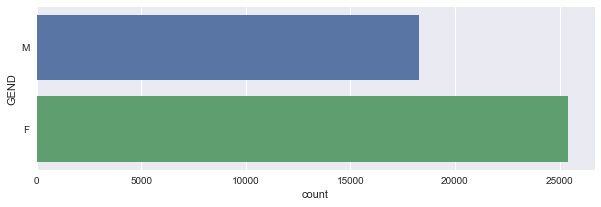

In [80]:
# 查看性别比例
plt.figure(1 , figsize = (10 , 3))
sns.countplot(y = 'GEND' , data = df)
plt.show()

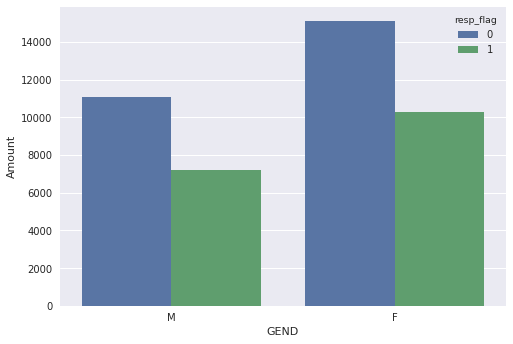

In [27]:
sns.countplot(x='GEND', hue='resp_flag', data=df); #设置 x,y 以及颜色控制的变量,以及画图的数据
plt.xlabel('GEND');
plt.ylabel('Amount');

### 学历情况

0-unknown; 1-初中；2-高中不到；3-高中毕业；4-大学未毕业；
5-大专；6-本科；7-研究生；8-专业院校毕业；9-博士

In [95]:
df.c210mys.value_counts()

4    18597
3    12437
6     7493
5     4474
2      462
7      130
0       60
1        9
8        4
Name: c210mys, dtype: int64

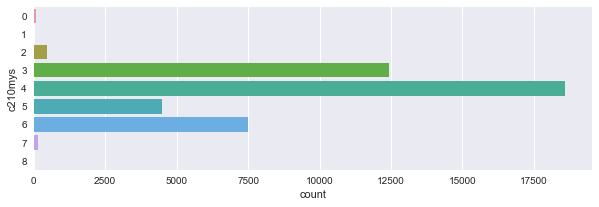

In [97]:
# 查看学历分布情况
plt.figure(1 , figsize = (10 , 3))
sns.countplot(y = 'c210mys' , data = df)
plt.show()

### 查看不同的学历之间购买保险比例

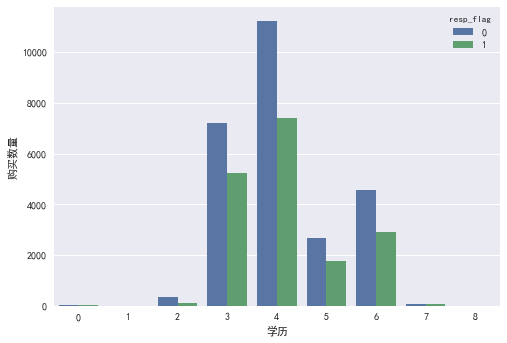

In [104]:
sns.countplot(x='c210mys', hue='resp_flag', data=df); #设置 x,y 以及颜色控制的变量,以及画图的数据
plt.xlabel('学历');
plt.ylabel('购买数量');

### 县级别和购买比例

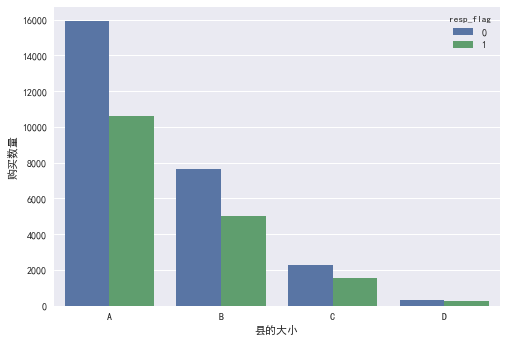

In [105]:
sns.countplot(x='N2NCY', hue='resp_flag', data=df); #设置 x,y 以及颜色控制的变量,以及画图的数据
plt.xlabel('县的大小');
plt.ylabel('购买数量');

## 空值填充

### 练习题: 请同学们把含有空值的列中, 每一列的数据类型统计出来

**答案**

In [113]:
# 首先统计一下这些特征中都属于什么数据类型
#NA['features']

In [124]:
df.dtypes[NA['features']].values

array([dtype('O'), dtype('O'), dtype('O'), dtype('O'), dtype('O'),
       dtype('O'), dtype('O'), dtype('float64'), dtype('O'), dtype('O'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64'), dtype('float64'), dtype('float64'),
       dtype('float64')], dtype=object)

In [125]:
# 通过索引来提取有空缺值的这些特征的类型

NA['数据类型'] = df.dtypes[NA['features']].values

In [126]:
NA

,features,Missing_count,数据类型
0,AASN,10,object
1,ASKN,8,object
2,COLLEGE,8,object
3,MOBPLUS,7,object
4,N2NCY,10,object
5,NY8Y9,9,object
6,POEP,8,object
7,LIVEWELL,5,float64
8,HOMSTAT,10,object
9,HINSUB,11,object


### 空值填充策略:

分类变量: 对于数据中的分类变量, 我们统一采用众数进行填充, 通常哪个分类水平出现的次数多, 这个出现的概率就是最高的.

数值型变量: 有一些变量虽然看起来是数值,但是已经是经过分箱之后的结果, 所以其实也是分类变量.

例如幸福指数LIVEWELL, 收入所处排名c210cip等

为了方便,我们把这些空值数据中,由什么样的值构成添加成一列

In [128]:
df['c210psu'].value_counts()

99.0    6996
98.0    1213
0.0     1193
97.0    1043
95.0     994
        ... 
14.0     142
19.0     139
17.0     138
27.0     123
24.0     122
Name: c210psu, Length: 100, dtype: int64

决定, 除年龄之外的其他特征, 我们采取众数进行填充. 年龄采取均值进行填充

In [131]:
#首先将NA中的列名,去除掉年龄age这个
NA[NA['features'] != 'age']

,features,Missing_count,数据类型
0,AASN,10,object
1,ASKN,8,object
2,COLLEGE,8,object
3,MOBPLUS,7,object
4,N2NCY,10,object
5,NY8Y9,9,object
6,POEP,8,object
7,LIVEWELL,5,float64
8,HOMSTAT,10,object
9,HINSUB,11,object


In [137]:
df['AASN'].fillna(df['AASN'].mode()[0], inplace = True)

In [156]:
#对每一行，做操作
def fillna_apply(i):
    # 将这一行的featrues提出来
    colname = i.values[0]  # 陈俊龄优化
    # 判断特征是否为age
    if colname != 'age':
        # 不为age，用众数填充
        df[colname].fillna(df[colname].mode()[0], inplace = True)
    else:
        # 为age,直接用平均值填充
        df[colname].fillna(df[colname].mean(), inplace = True)


# 对这些列名进行遍历, 依次进行填充
NA.apply(lambda i : fillna_apply(i), axis = 1)

### 确认是否全部填充完全

In [149]:
df.isnull().sum().sum()

0

## 变量编码

### 首先把用户ID列删除

In [29]:
del df['KBM_INDV_ID']

In [30]:
df.head(10)

,resp_flag,GEND,CA00,CA03,CA06,CA11,CA16,AART,ADBT,ADEP,...,c210pmr,c210poo,c210psu,c210pwc,c210wht,ilor,meda,pdpe,tins,zhip19
0,0,M,4,0,5,1,1,N,N,N,...,52,65,71.0,22,79.0,15.0,64.0,42,8,8
1,0,M,0,0,0,0,0,N,N,N,...,44,81,99.0,37,65.0,17.0,61.0,46,6,3
2,0,F,0,0,0,0,0,N,N,N,...,38,44,62.0,44,47.0,20.0,61.0,46,7,3
3,0,F,0,4,0,0,0,N,N,N,...,45,71,99.0,39,71.0,4.0,62.0,37,8,9
4,0,F,0,0,0,0,0,N,N,N,...,32,13,36.0,15,65.0,9.0,61.0,37,4,3
5,0,F,0,0,0,0,0,Y,N,N,...,37,50,80.0,32,53.0,17.0,61.0,46,14,2
6,0,F,0,0,0,0,0,N,N,N,...,61,92,99.0,35,75.0,21.0,61.0,46,12,7
7,0,M,0,0,0,0,0,N,N,N,...,45,46,99.0,19,83.0,8.0,61.0,46,4,9
8,0,M,4,1,3,0,0,N,N,N,...,30,61,99.0,25,71.0,41.0,61.0,46,9,6
9,0,F,0,0,0,0,0,N,N,N,...,19,18,99.0,4,76.0,12.0,61.0,46,2,1


In [165]:
object_cols = df.dtypes[df.dtypes == 'object'].index.tolist()
# df_object = df.select_dtypes('object')

In [195]:
object_cols

['GEND',
 'AART',
 'ADBT',
 'ADEP',
 'AHBP',
 'AHCH',
 'ARES',
 'AHRT',
 'AASN',
 'ADGS',
 'AHRL',
 'ASKN',
 'AVIS',
 'BANK',
 'COLLEGE',
 'FINI',
 'INLI',
 'INMEDI',
 'INVE',
 'IOLP',
 'MOBPLUS',
 'N2NCY',
 'NY8Y9',
 'N2N29',
 'N3N39',
 'N4N49',
 'N5N59',
 'N6N64',
 'N65P',
 'ONLA',
 'POEP',
 'SGFA',
 'SGLL',
 'SGOE',
 'SGSE',
 'SGTC',
 'U18',
 'POC19',
 'HOMSTAT',
 'HINSUB',
 'STATE_NAME']

In [183]:
# 对任意一个object类型的特征，来做编码的函数

def encode(col_name):
    # 从数据集里面取出特征
    col = df[col_name]
    
    # 算出unique的值，['S', 'P', 'M', 'U']
    levels = col.unique()
    
    # 计算出这个的长度，使用range来生成一个range(4) = list[0,1,2,3]
    size = range(len(levels))
    
    # 使用zip加上列表解析的方式来进行字典的创建
    d = {i : j for i,j in zip(levels, size)}
    df[col_name].replace(d, inplace = True)

In [194]:
## 下面的步骤是来解释上面的函数

In [184]:
# 对每一个是object的特征来进行编码
for col_name in object_cols:
    encode(col_name)

In [188]:
# 我们依然采用pandas进行数据编码
df['MOBPLUS'].unique()

array([0, 1, 2, 3])

In [189]:
#df['MOBPLUS'].replace({i : j for i, j in zip(M, N)})

In [172]:
# 举例子，使用zip加上列表解析的方式来进行字典的创建
M = ['S', 'P', 'M', 'U']
N = [0, 1, 2, 3]

# list的形式
[(i, j) for i, j in zip(M, N)]

[('S', 0), ('P', 1), ('M', 2), ('U', 3)]

In [191]:
# 字典的形式
{i : j for i, j in zip(M, N)}

{'S': 0, 'P': 1, 'M': 2, 'U': 3}

In [192]:
#在replace里面放入字典，就可以尝试将原来的字符型的值做一个替换达到编码的效果
#df['MOBPLUS'].replace({i : j for i, j in zip(M, N)})

**如此一来我们就编码成功了**

In [193]:
df.head(10)

,GEND,CA00,CA03,CA06,CA11,CA16,AART,ADBT,ADEP,AHBP,...,c210poo,c210psu,c210pwc,c210wht,ilor,meda,pdpe,tins,zhip19,label
0,0,4,0,5,1,1,0,0,0,0,...,65,71.0,22,79.0,15.0,64.0,42,8,8,0
1,0,0,0,0,0,0,0,0,0,0,...,81,99.0,37,65.0,17.0,61.0,46,6,3,0
2,1,0,0,0,0,0,0,0,0,0,...,44,62.0,44,47.0,20.0,61.0,46,7,3,0
3,1,0,4,0,0,0,0,0,0,0,...,71,99.0,39,71.0,4.0,62.0,37,8,9,0
4,1,0,0,0,0,0,0,0,0,0,...,13,36.0,15,65.0,9.0,61.0,37,4,3,0
5,1,0,0,0,0,0,1,0,0,0,...,50,80.0,32,53.0,17.0,61.0,46,14,2,0
6,1,0,0,0,0,0,0,0,0,0,...,92,99.0,35,75.0,21.0,61.0,46,12,7,0
7,0,0,0,0,0,0,0,0,0,0,...,46,99.0,19,83.0,8.0,61.0,46,4,9,0
8,0,4,1,3,0,0,0,0,0,0,...,61,99.0,25,71.0,41.0,61.0,46,9,6,0
9,1,0,0,0,0,0,0,0,0,0,...,18,99.0,4,76.0,12.0,61.0,46,2,1,0


注: 还可以采用哑变量对数据进行编码, 这里我们仅仅是采用分类变量编码的方式对数据进行了替换.

我们先用这种方式建模, 观察结果, 然后再使用哑变量转换数据, 对两种方式的效果进行对比.

## 进行机器学习建模

### 切分数据集

将数据集切分成训练数据和测试数据

In [219]:
from sklearn import tree
from sklearn.model_selection  import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
#from sklearn import cross_validation, metrics
from sklearn import metrics
from sklearn.model_selection import cross_val_score
#from sklearn.grid_search import GridSearchCV
from sklearn.model_selection import GridSearchCV
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams

In [197]:
df.head()

,GEND,CA00,CA03,CA06,CA11,CA16,AART,ADBT,ADEP,AHBP,...,c210poo,c210psu,c210pwc,c210wht,ilor,meda,pdpe,tins,zhip19,label
0,0,4,0,5,1,1,0,0,0,0,...,65,71.0,22,79.0,15.0,64.0,42,8,8,0
1,0,0,0,0,0,0,0,0,0,0,...,81,99.0,37,65.0,17.0,61.0,46,6,3,0
2,1,0,0,0,0,0,0,0,0,0,...,44,62.0,44,47.0,20.0,61.0,46,7,3,0
3,1,0,4,0,0,0,0,0,0,0,...,71,99.0,39,71.0,4.0,62.0,37,8,9,0
4,1,0,0,0,0,0,0,0,0,0,...,13,36.0,15,65.0,9.0,61.0,37,4,3,0


In [198]:
# 取出x和y
x = df.iloc[:, :-1]
y = df.iloc[:, -1]

In [200]:
# 将数据集7：3分，70%用来建模，30%用来测试
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3 ,random_state=66)

### 用默认模型试一下

In [211]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier()
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

(1.0, 0.5912977099236641)

In [215]:
clf.min_samples_split

2

### 尝试调参

### 决策树中参数的含义解释如下

In [216]:
clf = DecisionTreeClassifier(
            class_weight=None, #指定样本各类别的的权重，如果样本类别分布没有明显的偏倚，则可以不管这个参数，选择默认的"None"
            criterion='gini',#特征选择标准,可以使用"gini"或者"entropy"，前者代表基尼系数，后者代表信息增益。一般说使用默认的基尼系数"gini"就可以了，即CART算法。除非你更喜欢类似ID3, C4.5的最优特征选择方法。 
            max_depth=300,#决策树最大深,常用的可以取值10-100之间。主要是限制树的增长
            max_features=None,#划分时考虑的最大特征数
            max_leaf_nodes=None,#最大叶子节点数。通过限制最大叶。这个值限制了决策树的增长
            min_samples_leaf=10, #叶子节点最少样本数，用于减枝
            min_samples_split=10,#内部节点再划分所需最小样本数，这个值限制了子树继续划分的条件
            min_weight_fraction_leaf=0.0, #叶子节点最小的样本权重和。这个值限制了叶子节点所有样本权重和的最小值，如果小于这个值，则会和兄弟节点一起被剪枝。 默认是0，就是不考虑权重问题。一般来说，如果我们有较多样本有缺失值，或者分类树样本的分布类别偏差很大，就会引入样本权重，这时我们就要注意这个值了。
            presort=False, #数据是否预排序
            splitter='best' #特征划分点选择标准,可以使用"best"或者"random"。前者在特征的所有划分点中找出最优的划分点。后者是随机的在部分划分点中找局部最优的划分点。
            )
clf.fit(X_train, y_train)
clf.score(X_train, y_train), clf.score(X_test, y_test)

/Users/xiangyangni/anaconda3/lib/python3.7/site-packages/sklearn/tree/_classes.py:327: FutureWarning: The parameter 'presort' is deprecated and has no effect. It will be removed in v0.24. You can suppress this warning by not passing any value to the 'presort' parameter.
  FutureWarning)


(0.8119151998953085, 0.6164885496183206)

### 我们尝试使用最小叶节点样本数量和最小分割样本数量进行调参



In [224]:
list(range(1,50, 5))

[1, 6, 11, 16, 21, 26, 31, 36, 41, 46]

In [225]:
np.linspace(0,1, 10)

array([0.        , 0.11111111, 0.22222222, 0.33333333, 0.44444444,
       0.55555556, 0.66666667, 0.77777778, 0.88888889, 1.        ])

### 尝试使用最大深度和最小叶节点数量进行调参

In [228]:
clf = tree.DecisionTreeClassifier()

param_test= {'max_depth': range(3,15),
             'min_samples_leaf': range(200,3000,100),
             
            }

parameters = {'splitter':('best','random')
              ,'criterion':("gini","entropy")
              ,"max_depth":list(range(5,15))
              ,'min_samples_leaf':list(range(100,300,10))
              ,'min_impurity_decrease':[*np.linspace(0,0.5,20)]
             }

gsearch = GridSearchCV(estimator=clf,
                       param_grid = param_test,n_jobs=-1, cv=5)
gsearch.fit(X_train,y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(3, 15),
                         'min_samples_leaf': range(200, 3000, 100)})

In [229]:
# 在训练集上，模型最好的参数
gsearch.best_params_

{'max_depth': 9, 'min_samples_leaf': 200}

In [232]:
# 在训练集上，模型最好的分数
gsearch.best_score_

0.6564484778841575

### 模型评估

In [233]:
y_pred = gsearch.predict(X_test)

In [234]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sn

In [235]:
print('accuracy:',accuracy_score(y_test,y_pred))
print('precision:',precision_score(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred,labels=[1,0])
print('confusion matrix',cm)

accuracy: 0.6413740458015267
precision: 0.6066689350119088
confusion matrix [[1783 3542]
 [1156 6619]]


### 输出规则

#### 安装graphviz

scikit-learn中决策树的可视化一般需要安装graphviz。主要包括graphviz的安装和anaconda的graphviz插件的安装。

第一步是安装graphviz。下载地址在：https://graphviz.gitlab.io/_pages/Download/Download_windows.html 。下载msi/zip文件安装，装完后都要设置环境变量，将graphviz的bin目录加到PATH，比如我是windows，将C:/Program Files (x86)/Graphviz2.38/bin/加入了PATH

第二步是安装anaconda插件pydotplus: pip install pydotplus

这样环境就搭好了，有时候anaconda/python 会很笨，仍然找不到graphviz，这时，可以在代码里面加入这一行：

os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'

注意后面的路径是你自己的graphviz的bin目录。

In [252]:
from sklearn.metrics import accuracy_score
clf = tree.DecisionTreeClassifier(criterion = 'gini', max_depth = 9, min_samples_leaf=200)
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)
print(accuracy_score(y_test,y_pred))


0.6413740458015267


In [253]:
features= list(df.columns[1:]) 

In [254]:
dot_data = tree.export_graphviz(clf
                    ,feature_names= features,
                    class_names=['No Purchase',"Purchase"],       #字符串列表形式，默认为空，指定目标类的名称
                     filled=True,                     #默认False，对节点着色以显示多数类
                     rounded=True,                    #默认为False，若为True，节点框为圆角且用赫维提卡体代替默认的罗马字体
                     #rotate=True,                    #默认为False，若为True，树将长成左右结构，而不是默认的上下结构
                     impurity=True,                   #默认为True，是否为每个节点输出不纯度
                     leaves_parallel=False,         #默认为False,是否在树的底部画出叶节点
                     node_ids=True
                               )

In [255]:
import graphviz # pip install graphviz 安装

In [256]:
#import pydotplus #  pip install pydotplus  安装
#from IPython.display import Image

In [257]:
graph = graphviz.Source(dot_data)

In [258]:
# 输出PDF文件
graph.render("wine")

'wine.pdf'

### 使用随机森林尝试建模

In [248]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
rfc.score(X_test, y_test)

D:\Anaconda\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.6315267175572519

In [250]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=200)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
print(rfc.score(X_train, y_train))
rfc.score(X_test, y_test)

1.0


0.6670992366412214

In [251]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=1000)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
print(rfc.score(X_train, y_train))
rfc.score(X_test, y_test)

1.0


0.6680916030534351

In [253]:
rfc = RandomForestClassifier(n_estimators=200,max_depth = 15)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
print(rfc.score(X_train, y_train))
rfc.score(X_test, y_test)

0.8900739383628868


0.6654961832061068

In [260]:
rfc = RandomForestClassifier(n_estimators=500,max_depth = 12, class_weight="balanced",
                            criterion='entropy',)
rfc.fit(X_train,y_train)
y_pred = rfc.predict(X_test)
print(rfc.score(X_train, y_train))
rfc.score(X_test, y_test)

0.7884577635281032


0.6426717557251909

In [261]:
from sklearn.ensemble import AdaBoostClassifier

In [263]:
ada = AdaBoostClassifier(n_estimators=500,)
ada.fit(X_train,y_train)
y_pred = ada.predict(X_test)
print(ada.score(X_train, y_train))
ada.score(X_test, y_test)

0.6827193613819277


0.6561832061068702

In [248]:
clf.feature_importances_

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.01838839, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.51307185,
       0.18692639, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.08266373, 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.11284276,
       0.00696045, 0.00412978, 0.07501665, 0.        ])

In [251]:
FI = pd.Series(clf.feature_importances_, index = df.columns[:-1])
FI[FI > 0]

N2NCY         0.018388
STATE_NAME    0.513072
age           0.186926
c210hva       0.082664
ilor          0.112843
meda          0.006960
pdpe          0.004130
tins          0.075017
dtype: float64